In [ ]:
#%%

%load_ext autoreload
%autoreload 2

from selfmod import NumpyLoader, make_image, make_run_folder, setup_run_folder
from piedpiper import *

## For reproducibility
seed = 2026

## Dataloader hps
k_shots = 100
resolution = (32, 32)
H, W, C = (*resolution, 3)

data_folder="../../../Self-Mod/examples/celeb-a/data/"
# data_folder="/Users/ddrous/Projects/Self-Mod/examples/celeb-a/data/"
shuffle = False
num_workers = 0
latent_chans = 16

envs_batch_size = 2
envs_batch_size_all = envs_batch_size
num_batches = 4*1

init_lr = 5e-5
nb_epochs = 2500
print_every = 500
validate_every = 1000
sched_factor = 1.0
eps = 1e-6  ## Small value to avoid division by zero

# run_folder = None
run_folder = "./runs/241022-193555-Good/"

meta_train = True


############# Contextual Self-Modulation #############

Jax version: 0.4.34
Available devices: [CpuDevice(id=0)]

############# Pied Piper Video Compression #############

Jax version: 0.4.34
Available devices: [CpuDevice(id=0)]


In [ ]:
#%%

if run_folder==None:
    run_folder = make_run_folder('./runs/')
else:
    print("Using existing run folder:", run_folder)

_ = setup_run_folder(run_folder, os.path.basename(__file__))


# os.listdir(data_folder)

Using existing run folder: ./runs/241022-193555-Good/
Completed copied scripts 


In [ ]:
#%% 

mother_key = jax.random.PRNGKey(seed)
data_key, model_key, trainer_key, test_key = jax.random.split(mother_key, num=4)

train_dataset = ImageDataset(data_folder, 
                            data_split="train",
                            num_shots=k_shots, 
                            order_pixels=False, 
                            resolution=resolution,
                            max_envs=envs_batch_size*num_batches,
                            )
train_dataloader = NumpyLoader(train_dataset, 
                              batch_size=envs_batch_size, 
                              shuffle=shuffle,
                              num_workers=num_workers,
                              drop_last=False)

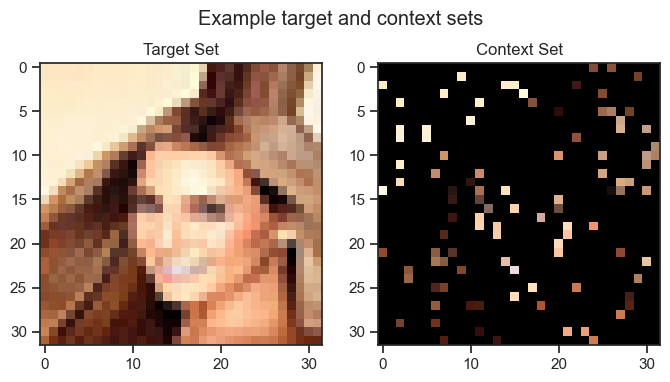

In [ ]:
#%% 

gen_train_dataloader = iter(train_dataloader)

batch = next(gen_train_dataloader)
# print([dat.shape for dat in batch])

dat_context, dat_target = batch
Xc, Yc = dat_context[0,..., :2], dat_context[0,..., 2:]
Xt, Yt = dat_target[0,..., :2], dat_target[0,..., 2:]

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
img = make_image(Xt, Yt, img_size=(*resolution, 3))
axs[0].imshow(img)
axs[0].set_title("Target Set")

img_fs = make_image(Xc, Yc, img_size=(*resolution, 3))
axs[1].imshow(img_fs)
axs[1].set_title("Context Set")
plt.suptitle("Example target and context sets");

In [ ]:
#%%

class ConvCNP(eqx.Module):
    encoder: eqx.Module
    decoder: eqx.Module
    positivity: callable

    def __init__(self, latent_chans=8, key=None):
        super().__init__()
        ## From the ConvCNP paper, Figure 1c
        keys = jax.random.split(key, 2)
        self.encoder = Encoder(C, H, W, key=keys[0])    ## E
        self.decoder = Decoder(C, H, W, in_chans=C, out_chans=latent_chans, key=keys[1])    ## rho
        self.positivity = lambda x: jnp.clip(jax.nn.softplus(x), eps, 1)

    def preprocess(self, XY):
        X, Y = XY[..., :2], XY[..., 2:]
        img = jnp.zeros((C, H, W))
        mask = jnp.zeros((1, H, W))
        i_locs = (X[:, 0] * H).astype(int)
        j_locs = (X[:, 1] * W).astype(int)
        img = img.at[:, i_locs, j_locs].set(jnp.clip(Y, 0., 1.).T)
        mask = mask.at[:, i_locs, j_locs].set(1.)
        return img, mask

    def preprocess_channel_last(self, XY):
        img, mask = self.preprocess(XY)
        return img.transpose(1, 2, 0), mask.transpose(1, 2, 0)

    def postprocess(self, mu, sigma):
        mu = jnp.transpose(mu, (1, 2, 0))
        sigma = jnp.transpose(sigma, (1, 2, 0))
        return mu, sigma

    def __call__(self, ctx_imgs):

        def predict(ctx_img):
            Ic, Mc = self.preprocess(ctx_img)   ## Context pixels and their location
            hc = self.encoder(Mc, Ic)   ## Normalized convolution

            ft = self.decoder(hc)
            mu, sigma = jnp.split(ft, 2, axis=0)
            # jax.debug.print("sigma is {}", sigma)
            sigma = self.positivity(sigma)

            mu, sigma = self.postprocess(mu, sigma)  ## Reshape into 2D arrays = (H, W, C)

            return mu, sigma    ## Shape: (H, W, C)

        return eqx.filter_vmap(predict)(ctx_imgs)


model = ConvCNP(latent_chans=latent_chans, key=model_key)

def loss_fn(model, batch):
    ctx_data, tgt_data = batch
    # Xc shape: (B, K, 2), Yc shape: (B, K, C), Yt shape: (B, 1024, C)

    ys, _ = eqx.filter_vmap(model.preprocess_channel_last)(tgt_data)

    mus, sigmas = model(ctx_data)    ## mu, sigma shape: (B, H, W, C)



    losses = neg_log_likelihood(mus, sigmas, ys)
    # return losses.sum(axis=(1, 2)).mean()
    return losses.mean()


## Define the learner
learner = Learner(model, loss_fn)

print("Data context shape is:", dat_context.shape)

Data context shape is: (2, 100, 5)


In [ ]:
#%%

## Define optimiser and train the model
total_steps = nb_epochs*train_dataloader.num_batches
bd_scales = {total_steps//3:sched_factor, 2*total_steps//3:sched_factor}
sched = optax.piecewise_constant_schedule(init_value=init_lr, boundaries_and_scales=bd_scales)
opt = optax.chain(optax.clip(1e-0), optax.adam(sched))


trainer = Trainer(learner, opt)

## Training loop
if meta_train:
    trainer.meta_train(train_dataloader,
                        nb_epochs=nb_epochs,
                        print_every=print_every,
                        save_checkpoints=True,
                        save_path=run_folder,
                        val_dataloader=train_dataloader,
                        val_criterion="NLL",
                        validate_every=validate_every,
                        )
else:
    trainer.restore_trainer(run_folder)

20:05:07      Epoch:   0      Loss: 1.07448566      Time/Epoch(s): 1.0258
    Validation loss: 1.0734546184539795
    Best model saved at epoch 0 with validation loss: 1.0734546184539795
20:05:47      Epoch: 500      Loss: 0.59275728      Time/Epoch(s): 0.0754
20:06:26      Epoch: 1000      Loss: 0.58501345      Time/Epoch(s): 0.0778
    Validation loss: 0.5390166640281677
    Best model saved at epoch 1000 with validation loss: 0.5390166640281677
20:07:07      Epoch: 1500      Loss: 0.47345999      Time/Epoch(s): 0.0791
20:07:46      Epoch: 2000      Loss: 0.41385835      Time/Epoch(s): 0.0755
    Validation loss: 0.4213312566280365
    Best model saved at epoch 2000 with validation loss: 0.4213312566280365
20:08:26      Epoch: 2499      Loss: 0.35052371      Time/Epoch(s): 0.0781


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Plotting 2 environments


/Users/ddrous/miniconda3/envs/jaxgpu/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


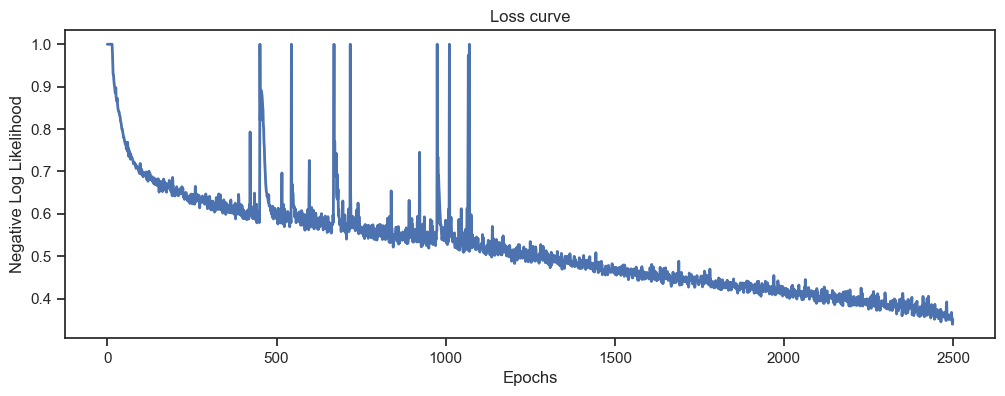

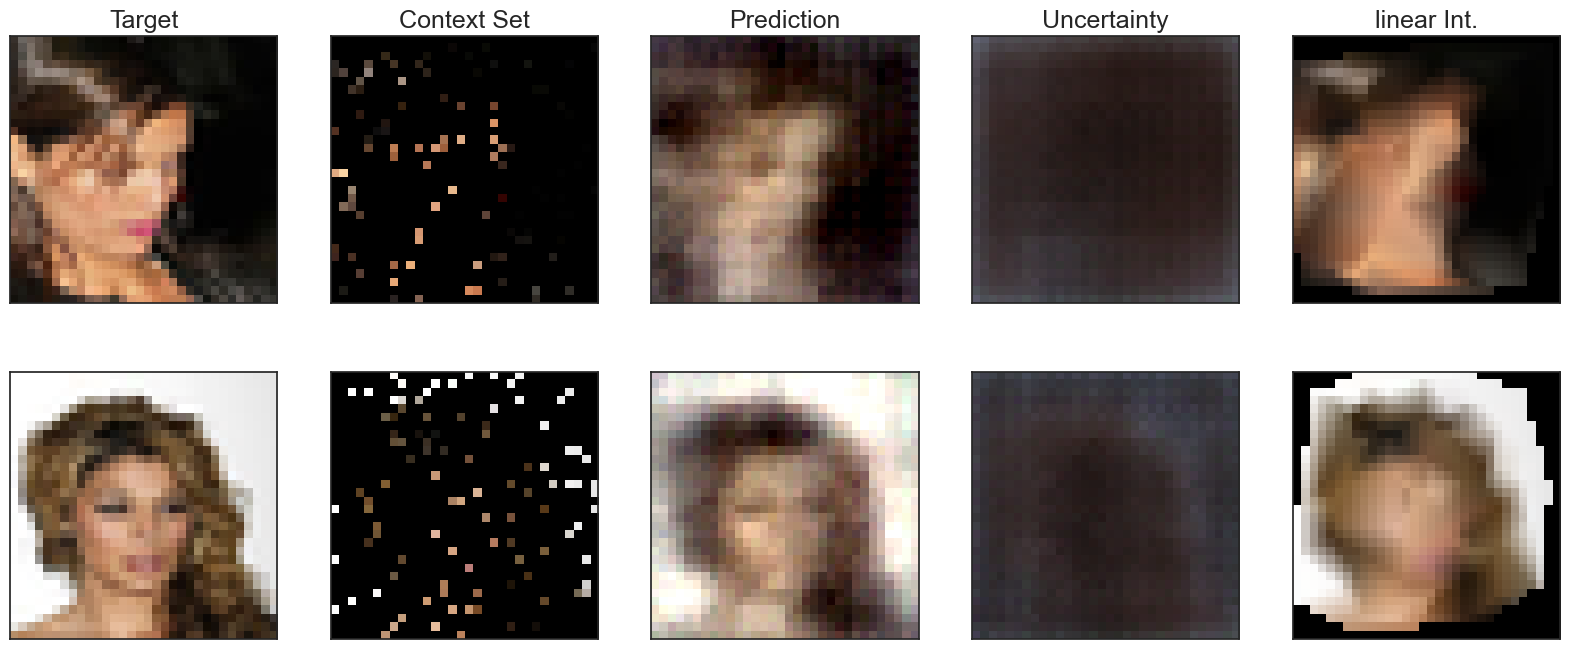

In [ ]:
#%%

# print("Training losses:", jnp.stack(trainer.train_losses))

visualtester = VisualTester(trainer)
visualtester.visualize_losses(run_folder, log_scale=False, ylim=1)

test_dataset = ImageDataset(data_folder, 
                            data_split="test",
                            num_shots=k_shots, 
                            order_pixels=False, 
                            resolution=resolution,
                            max_envs=envs_batch_size*num_batches,
                            )
test_dataloader = NumpyLoader(train_dataset, 
                              batch_size=envs_batch_size, 
                              shuffle=True,
                              num_workers=num_workers,
                              drop_last=False)

visualtester.visualize_images(test_dataloader, nb_envs=2, key=test_key, save_path=run_folder, interp_method="linear")

In [ ]:
#%%

try:
    __IPYTHON__ ## in a jupyter notebook
except NameError:
    os.system(f"cp nohup.log {run_folder}")